## Human Pose Classification with MoveNet and TensorFlow Lite

This notebook teaches you how to train a pose classification model using MoveNet and TensorFlow Lite. The result is a new TensorFlow Lite model that accepts the output from the MoveNet model as its input, and outputs a pose classification

## Preparation

In this section, you'll import the necessary libraries and define several functions to preprocess the training images into a CSV file that contains the landmark coordinates and ground truth labels.

In [ ]:
import csv
import cv2
import itertools
import numpy as np
import pandas as pd
import os
import sys
import tempfile
import tqdm

from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
from IPython.display import Image, display

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

## Train a pose classification model that takes the landmark coordinates as input, and output the predicted labels.

Build a TensorFlow model that takes the landmark coordinates and predicts the pose class that the person in the input image performs. The model are created by feeding normalized pose coordinates with video resolution through several `Dense` layer to predict the pose class.

You'll then train the model based on the dataset that were preprocessed in previous notebook

### Load the preprocessed CSVs into `TRAIN` and `TEST` datasets.

In [ ]:
csv_root = "exercise/csv"
path_exercise = os.path.join(csv_root, "supportedShoulderRange.csv")
path_dance = os.path.join(csv_root, "woozooDance.csv")

In [ ]:
df_exercise = pd.read_csv(path_exercise)
df_exercise.columns = map(str.lower, df_exercise.columns)
df_exercise = df_exercise[df_exercise.columns.drop(list(df_exercise.filter(regex='_score')))]
df_exercise.drop(columns=['file_name', 'class_no'], inplace=True)
df_exercise["class_name"] = "Shoulder Range"

In [ ]:
df_exercise

,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,right_ear_y,...,right_hip_y,left_knee_x,left_knee_y,right_knee_x,right_knee_y,left_ankle_x,left_ankle_y,right_ankle_x,right_ankle_y,class_name
0,311.0,492.0,297.0,505.0,292.0,510.0,306.0,550.0,303.0,558.0,...,544.0,846.0,558.0,837.0,569.0,1067.0,594.0,1071.0,605.0,Shoulder Range
1,310.0,492.0,296.0,506.0,292.0,511.0,307.0,551.0,304.0,560.0,...,544.0,852.0,560.0,841.0,566.0,1070.0,594.0,1073.0,601.0,Shoulder Range
2,312.0,493.0,298.0,505.0,293.0,511.0,307.0,551.0,303.0,559.0,...,544.0,849.0,559.0,838.0,566.0,1069.0,596.0,1073.0,602.0,Shoulder Range
3,314.0,492.0,300.0,504.0,296.0,512.0,311.0,548.0,307.0,561.0,...,545.0,849.0,558.0,840.0,572.0,1070.0,593.0,1073.0,603.0,Shoulder Range
4,316.0,492.0,302.0,506.0,297.0,511.0,312.0,550.0,308.0,561.0,...,548.0,847.0,557.0,839.0,572.0,1065.0,595.0,1069.0,607.0,Shoulder Range
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,312.0,492.0,297.0,504.0,293.0,509.0,307.0,550.0,304.0,557.0,...,550.0,855.0,554.0,842.0,569.0,1065.0,588.0,1074.0,601.0,Shoulder Range
380,310.0,494.0,295.0,506.0,291.0,511.0,307.0,551.0,305.0,557.0,...,545.0,851.0,555.0,839.0,568.0,1065.0,589.0,1074.0,602.0,Shoulder Range
381,312.0,490.0,296.0,503.0,294.0,508.0,307.0,549.0,305.0,555.0,...,545.0,855.0,554.0,842.0,567.0,1066.0,590.0,1076.0,602.0,Shoulder Range
382,310.0,491.0,295.0,504.0,292.0,508.0,306.0,550.0,304.0,556.0,...,546.0,849.0,556.0,837.0,567.0,1064.0,589.0,1072.0,601.0,Shoulder Range


In [ ]:
df_dance = pd.read_csv(path_dance)
df_dance.columns = map(str.lower, df_dance.columns)
df_dance = df_dance[df_dance.columns.drop(list(df_dance.filter(regex='_score')))]
df_dance.drop(columns=['file_name', 'class_no'], inplace=True)
df_dance["class_name"] = "other"

In [ ]:
df_dance

,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,right_ear_y,...,right_hip_y,left_knee_x,left_knee_y,right_knee_x,right_knee_y,left_ankle_x,left_ankle_y,right_ankle_x,right_ankle_y,class_name
0,308.0,126.0,312.0,125.0,303.0,125.0,318.0,131.0,299.0,132.0,...,214.0,322.0,269.0,307.0,272.0,308.0,315.0,321.0,322.0,other
1,316.0,166.0,319.0,164.0,312.0,164.0,323.0,166.0,308.0,168.0,...,231.0,328.0,284.0,307.0,285.0,327.0,321.0,312.0,319.0,other
2,315.0,169.0,318.0,166.0,311.0,166.0,322.0,168.0,307.0,170.0,...,233.0,324.0,280.0,305.0,284.0,327.0,322.0,310.0,317.0,other
3,314.0,170.0,318.0,167.0,310.0,167.0,321.0,169.0,307.0,170.0,...,233.0,323.0,279.0,304.0,284.0,325.0,310.0,307.0,312.0,other
4,313.0,170.0,317.0,167.0,309.0,167.0,321.0,169.0,306.0,169.0,...,234.0,316.0,271.0,302.0,274.0,320.0,296.0,306.0,310.0,other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
946,315.0,154.0,319.0,154.0,312.0,152.0,322.0,160.0,306.0,157.0,...,232.0,342.0,284.0,285.0,282.0,364.0,325.0,270.0,324.0,other
947,318.0,150.0,322.0,149.0,314.0,147.0,325.0,154.0,307.0,150.0,...,223.0,337.0,277.0,292.0,278.0,348.0,318.0,285.0,311.0,other
948,317.0,158.0,321.0,156.0,313.0,156.0,323.0,160.0,308.0,159.0,...,228.0,327.0,275.0,309.0,278.0,328.0,305.0,313.0,312.0,other
949,316.0,162.0,320.0,159.0,313.0,159.0,323.0,163.0,308.0,163.0,...,232.0,328.0,279.0,310.0,282.0,327.0,320.0,314.0,320.0,other


In [ ]:
def norm_by_resolution(df, width, height):
  for col in df.keys():
    axcol = col.split("_")[-1]
    if axcol == "x":
      df[col] = df[col] / width
    if axcol == "y":
      df[col] = df[col] / height

In [ ]:
X_dance = df_dance.drop(['class_name'], axis=1)
y_dance = df_dance['class_name']

In [ ]:
norm_by_resolution(X_dance, 606, 360)

In [ ]:
X_exercise = df_exercise.drop(['class_name'], axis=1)
y_exercise = df_exercise['class_name']

In [ ]:
norm_by_resolution(X_exercise, 1280, 720)

In [ ]:
X = pd.concat([X_dance, X_exercise], ignore_index=True, sort=False)
y = pd.concat([y_dance, y_exercise], ignore_index=True, sort=False)

In [ ]:
X

,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,right_ear_y,...,right_hip_x,right_hip_y,left_knee_x,left_knee_y,right_knee_x,right_knee_y,left_ankle_x,left_ankle_y,right_ankle_x,right_ankle_y
0,0.508251,0.350000,0.514851,0.347222,0.500000,0.347222,0.524752,0.363889,0.493399,0.366667,...,0.491749,0.594444,0.531353,0.747222,0.506601,0.755556,0.508251,0.875000,0.529703,0.894444
1,0.521452,0.461111,0.526403,0.455556,0.514851,0.455556,0.533003,0.461111,0.508251,0.466667,...,0.503300,0.641667,0.541254,0.788889,0.506601,0.791667,0.539604,0.891667,0.514851,0.886111
2,0.519802,0.469444,0.524752,0.461111,0.513201,0.461111,0.531353,0.466667,0.506601,0.472222,...,0.500000,0.647222,0.534653,0.777778,0.503300,0.788889,0.539604,0.894444,0.511551,0.880556
3,0.518152,0.472222,0.524752,0.463889,0.511551,0.463889,0.529703,0.469444,0.506601,0.472222,...,0.501650,0.647222,0.533003,0.775000,0.501650,0.788889,0.536304,0.861111,0.506601,0.866667
4,0.516502,0.472222,0.523102,0.463889,0.509901,0.463889,0.529703,0.469444,0.504950,0.469444,...,0.500000,0.650000,0.521452,0.752778,0.498350,0.761111,0.528053,0.822222,0.504950,0.861111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1330,0.243750,0.683333,0.232031,0.700000,0.228906,0.706944,0.239844,0.763889,0.237500,0.773611,...,0.500000,0.763889,0.667969,0.769444,0.657813,0.790278,0.832031,0.816667,0.839063,0.834722
1331,0.242188,0.686111,0.230469,0.702778,0.227344,0.709722,0.239844,0.765278,0.238281,0.773611,...,0.497656,0.756944,0.664844,0.770833,0.655469,0.788889,0.832031,0.818056,0.839063,0.836111
1332,0.243750,0.680556,0.231250,0.698611,0.229687,0.705556,0.239844,0.762500,0.238281,0.770833,...,0.500000,0.756944,0.667969,0.769444,0.657813,0.787500,0.832812,0.819444,0.840625,0.836111
1333,0.242188,0.681944,0.230469,0.700000,0.228125,0.705556,0.239063,0.763889,0.237500,0.772222,...,0.498437,0.758333,0.663281,0.772222,0.653906,0.787500,0.831250,0.818056,0.837500,0.834722


In [ ]:
y = pd.get_dummies(y).values
y

array([[False,  True],
       [False,  True],
       [False,  True],
       ...,
       [ True, False],
       [ True, False],
       [ True, False]])

In [ ]:
y_binary = y[:, 1]  # True/False labels are encoded as True=1, False=0

In [ ]:
# Split data into training (80%) and temp (20%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y_binary, test_size=0.2, random_state=42)

# Split the temp set equally into validation (10%) and test (10%) sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Output the size of each set
print(f"Training set: {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples")
print(f"Test set: {len(X_test)} samples")

Training set: 1068 samples
Validation set: 133 samples
Test set: 134 samples


### Model architecture

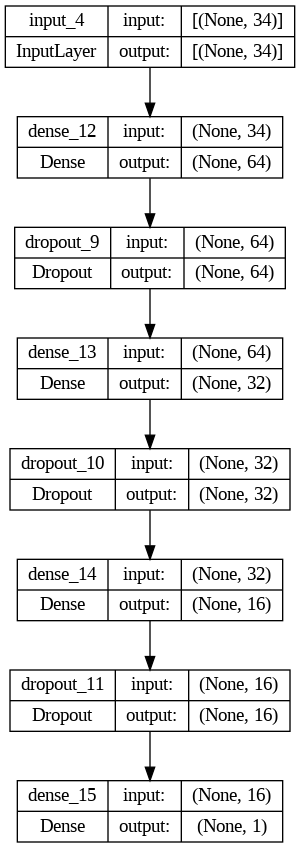

In [ ]:
# Ref: https://github.com/tringn/2D-Keypoints-based-Pose-Classifier
# Create the model
def my_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(X_train.shape[1],)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid')
        ])
    return model

model = my_model()

# Plot the model
plot_model(model, to_file='nn_model.png', show_shapes=True, show_layer_names=True)

display(Image('nn_model.png'))

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
# Train the model
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    batch_size=64,
    epochs=200
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)

Epoch 1/200
17/17 [==============================] - 2s 31ms/step - loss: 0.6937 - accuracy: 0.5693 - val_loss: 0.5955 - val_accuracy: 0.6917
Epoch 2/200
17/17 [==============================] - 0s 5ms/step - loss: 0.6047 - accuracy: 0.6863 - val_loss: 0.5441 - val_accuracy: 0.6917
Epoch 3/200
17/17 [==============================] - 0s 5ms/step - loss: 0.5579 - accuracy: 0.7238 - val_loss: 0.4533 - val_accuracy: 0.8120
Epoch 4/200
17/17 [==============================] - 0s 5ms/step - loss: 0.4810 - accuracy: 0.7912 - val_loss: 0.3466 - val_accuracy: 0.9850
Epoch 5/200
17/17 [==============================] - 0s 4ms/step - loss: 0.4073 - accuracy: 0.8352 - val_loss: 0.2431 - val_accuracy: 0.9925
Epoch 6/200
17/17 [==============================] - 0s 5ms/step - loss: 0.3383 - accuracy: 0.8811 - val_loss: 0.1770 - val_accuracy: 0.9925
Epoch 7/200
17/17 [==============================] - 0s 4ms/step - loss: 0.2742 - accuracy: 0.9148 - val_loss: 0.1199 - val_accuracy: 0.9925
Epoch 8/200


### Model evaluation

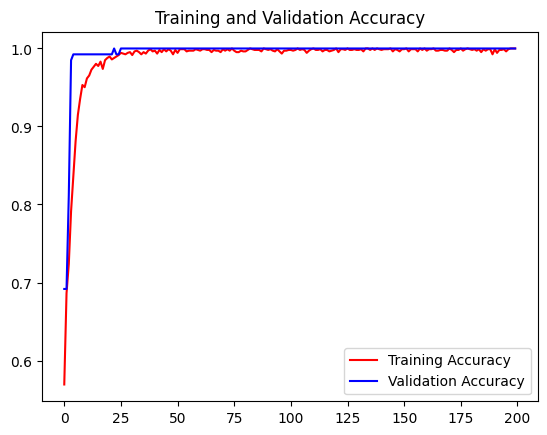

<Figure size 640x480 with 0 Axes>

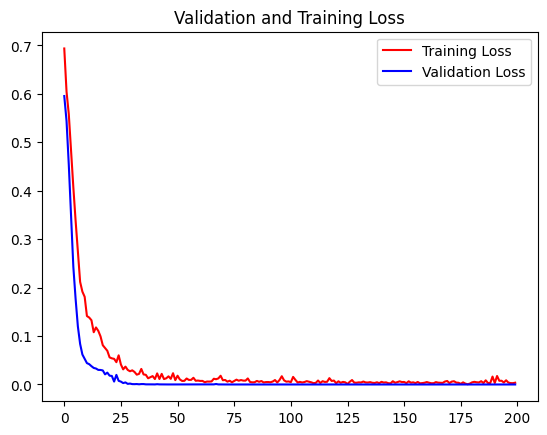

<Figure size 640x480 with 0 Axes>

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Validation and Training Loss')
plt.legend(loc=0)
plt.figure()
plt.show()

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 8.508935422923969e-08
Test accuracy: 1.0


In [ ]:
# Extract and sort class names from the DataFrame
class_names = np.sort(df_data['class_name'].unique())
class_names

array(['Shoulder Range', 'other'], dtype=object)

In [ ]:
# Sample a single instance from X_test
x_sample = X_test.sample(1)

# Predict probabilities for the sample using your trained model
predicted_probabilities = model.predict(x_sample)

# Get the index of the predicted class
predicted_class_index = np.argmax(predicted_probabilities, axis=1)[0]

# Print the predicted class index directly
print(f"Predicted Class Index is: {predicted_class_index}")

# Get the actual class name for the sampled instance
x_label_true = df_data.iloc[x_sample.index.values[0]]['class_name']

# Map the actual class name to its index in the class_names array
actual_class_index = np.where(class_names == x_label_true)[0][0]

# Print the actual class index
print(f"Actual Class Index is: {actual_class_index}")

1/1 [==============================] - 0s 35ms/step
Predicted Class Index is: 0
Actual Class Index is: 0


In [ ]:
RPS_SAVED_MODEL = "rps_saved_model"

In [ ]:
tf.saved_model.save(model, RPS_SAVED_MODEL)

In [ ]:
%%bash -s $RPS_SAVED_MODEL
saved_model_cli show --dir $1 --tag_set serve --signature_def serving_default

The given SavedModel SignatureDef contains the following input(s):
  inputs['input_1'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 34)
      name: serving_default_input_1:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['dense_3'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 1)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict


2024-06-21 04:02:49.242182: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-21 04:02:49.242257: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-21 04:02:49.245632: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-21 04:02:50.649491: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
loaded = tf.saved_model.load(RPS_SAVED_MODEL)

In [ ]:
print(list(loaded.signatures.keys()))
infer = loaded.signatures["serving_default"]
print(infer.structured_input_signature)
print(infer.structured_outputs)

['serving_default']
((), {'input_1': TensorSpec(shape=(None, 34), dtype=tf.float32, name='input_1')})
{'dense_3': TensorSpec(shape=(None, 1), dtype=tf.float32, name='dense_3')}


In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(RPS_SAVED_MODEL)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()

In [ ]:
tflite_model_file = 'exercise/ShoulderRange.tflite'

with open(tflite_model_file, "wb") as f:
    f.write(tflite_model)